In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader



In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 32


In [3]:
train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [4]:
val_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [5]:
test_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


### Load dataset

In [15]:
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import Subset

In [16]:
base_dataset = datasets.ImageFolder(root=r"D:\data science bootcamp\deeplearning\transfer_learning\image_data")

In [17]:
indices = list(range(len(base_dataset)))
targets = base_dataset.targets


In [21]:
len(targets)

9144

In [22]:
# Stratified Split: Train (80%), Val (10%), Test (10%)
# First, split off the training set
train_idx, temp_idx, _, temp_targets = train_test_split(
    indices, targets, test_size=0.20, stratify=targets, random_state=42
)

In [23]:
val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.50, stratify=temp_targets, random_state=42
)

In [24]:
class TransformedSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

In [25]:
train_dataset = TransformedSubset(Subset(base_dataset, train_idx), transform=train_transforms)
val_dataset = TransformedSubset(Subset(base_dataset, val_idx), transform=val_transforms)
test_dataset = TransformedSubset(Subset(base_dataset, test_idx), transform=test_transforms)

print(f"Total images: {len(base_dataset)}")
print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")

Total images: 9144
Train: 7315 | Val: 914 | Test: 915


In [38]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)


In [39]:
images, labels = next(iter(train_loader))
print(images.shape)
print(labels.shape)


torch.Size([32, 3, 224, 224])
torch.Size([32])


### Build CNN

In [41]:
import torch.nn.functional as F
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x


In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [48]:
num_classes = len(base_dataset.classes)

model = SimpleCNN(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


### Training Loop

In [49]:
def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    accuracy = 100 * correct / total

    return epoch_loss, accuracy


### Validation loop

In [50]:
def validate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    accuracy = 100 * correct / total

    return epoch_loss, accuracy


In [51]:
EPOCHS = 5

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer, criterion
    )

    val_loss, val_acc = validate(
        model, val_loader, criterion
    )

    print(f"Epoch [{epoch+1}/{EPOCHS}]")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.2f}%")
    print("-" * 50)


Epoch [1/5]
Train Loss: 3.6896 | Train Acc: 24.92%
Val   Loss: 3.1232 | Val   Acc: 33.48%
--------------------------------------------------
Epoch [2/5]
Train Loss: 2.7422 | Train Acc: 39.96%
Val   Loss: 2.6029 | Val   Acc: 42.34%
--------------------------------------------------
Epoch [3/5]
Train Loss: 2.3132 | Train Acc: 46.17%
Val   Loss: 2.3189 | Val   Acc: 47.26%
--------------------------------------------------
Epoch [4/5]
Train Loss: 1.9870 | Train Acc: 52.11%
Val   Loss: 2.1668 | Val   Acc: 47.70%
--------------------------------------------------
Epoch [5/5]
Train Loss: 1.7354 | Train Acc: 56.94%
Val   Loss: 1.9195 | Val   Acc: 54.27%
--------------------------------------------------


## Resnet 18

In [52]:
from torchvision import models

In [53]:
resnet18 = models.resnet18(pretrained=True)

c:\Users\Shrinivass\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Shrinivass\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [55]:
# Freezing layers 
for param in resnet18.parameters():
    param.requires_grad = False


In [60]:
resnet18.fc = nn.Linear(resnet18.fc.in_features,num_classes)



In [61]:
resnet18 = resnet18.to(device)


### training only fc layer

In [62]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    resnet18.fc.parameters(),  
    lr=0.001
)


In [63]:
EPOCHS = 5

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(
        resnet18, train_loader, optimizer, criterion
    )

    val_loss, val_acc = validate(
        resnet18, val_loader, criterion
    )

    print(f"Epoch [{epoch+1}/{EPOCHS}]")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.2f}%")
    print("-" * 50)


Epoch [1/5]
Train Loss: 2.1937 | Train Acc: 54.53%
Val   Loss: 0.9582 | Val   Acc: 80.53%
--------------------------------------------------
Epoch [2/5]
Train Loss: 0.8395 | Train Acc: 82.60%
Val   Loss: 0.6101 | Val   Acc: 85.01%
--------------------------------------------------
Epoch [3/5]
Train Loss: 0.5776 | Train Acc: 87.12%
Val   Loss: 0.4995 | Val   Acc: 86.76%
--------------------------------------------------
Epoch [4/5]
Train Loss: 0.4674 | Train Acc: 89.24%
Val   Loss: 0.4544 | Val   Acc: 87.42%
--------------------------------------------------
Epoch [5/5]
Train Loss: 0.3802 | Train Acc: 90.99%
Val   Loss: 0.4262 | Val   Acc: 88.84%
--------------------------------------------------


## Fine tuning

In [65]:
# freezing everything first
for param in resnet18.parameters():
    param.requires_grad = False

##### fine tuning 2nd layer of resnet18

In [66]:
for param in resnet18.layer2.parameters():
    param.requires_grad = True

In [67]:
for param in resnet18.fc.parameters():
    param.requires_grad = True

In [68]:
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, resnet18.parameters()),
    lr=1e-4
)

In [69]:
criterion = nn.CrossEntropyLoss()


In [70]:
EPOCHS = 5

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(
        resnet18, train_loader, optimizer, criterion
    )

    val_loss, val_acc = validate(
        resnet18, val_loader, criterion
    )

    print(f"Epoch [{epoch+1}/{EPOCHS}]")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.2f}%")
    print("-" * 50)


Epoch [1/5]
Train Loss: 0.2516 | Train Acc: 94.53%
Val   Loss: 0.3113 | Val   Acc: 91.36%
--------------------------------------------------
Epoch [2/5]
Train Loss: 0.2087 | Train Acc: 95.49%
Val   Loss: 0.2913 | Val   Acc: 91.25%
--------------------------------------------------
Epoch [3/5]
Train Loss: 0.1792 | Train Acc: 96.40%
Val   Loss: 0.2666 | Val   Acc: 92.89%
--------------------------------------------------
Epoch [4/5]
Train Loss: 0.1605 | Train Acc: 96.90%
Val   Loss: 0.2605 | Val   Acc: 92.45%
--------------------------------------------------
Epoch [5/5]
Train Loss: 0.1508 | Train Acc: 97.01%
Val   Loss: 0.2591 | Val   Acc: 92.67%
--------------------------------------------------


#### Fine tuning 4th layer of resnet 18

In [73]:
# freezing everything first
for param in resnet18.parameters():
    param.requires_grad = False

In [74]:
# Unfreeze layer4 (high-level features)
for param in resnet18.layer4.parameters():
    param.requires_grad = True


In [75]:
for param in resnet18.fc.parameters():
    param.requires_grad = True

In [76]:
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, resnet18.parameters()),
    lr=1e-4
)


In [77]:
EPOCHS = 5

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(
        resnet18, train_loader, optimizer, criterion
    )

    val_loss, val_acc = validate(
        resnet18, val_loader, criterion
    )

    print(f"Epoch [{epoch+1}/{EPOCHS}]")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.2f}%")
    print("-" * 50)


Epoch [1/5]
Train Loss: 0.1549 | Train Acc: 95.86%
Val   Loss: 0.1968 | Val   Acc: 93.98%
--------------------------------------------------
Epoch [2/5]
Train Loss: 0.0599 | Train Acc: 98.80%
Val   Loss: 0.1937 | Val   Acc: 93.98%
--------------------------------------------------
Epoch [3/5]
Train Loss: 0.0392 | Train Acc: 99.41%
Val   Loss: 0.1864 | Val   Acc: 94.75%
--------------------------------------------------
Epoch [4/5]
Train Loss: 0.0300 | Train Acc: 99.45%
Val   Loss: 0.1849 | Val   Acc: 94.86%
--------------------------------------------------
Epoch [5/5]
Train Loss: 0.0204 | Train Acc: 99.60%
Val   Loss: 0.1847 | Val   Acc: 94.31%
--------------------------------------------------


# Performance Analysis

In [78]:
import matplotlib.pyplot as plt


In [79]:
cnn_train_acc = [24.92, 39.96, 46.17, 52.11, 56.94]
cnn_val_acc   = [33.48, 42.34, 47.26, 47.70, 54.27]

cnn_train_loss = [3.6896, 2.7422, 2.3132, 1.9870, 1.7354]
cnn_val_loss   = [3.1232, 2.6029, 2.3189, 2.1668, 1.9195]


In [80]:
fc_train_acc = [54.53, 82.60, 87.12, 89.24, 90.99]
fc_val_acc   = [80.53, 85.01, 86.76, 87.42, 88.84]

fc_train_loss = [2.1937, 0.8395, 0.5776, 0.4674, 0.3802]
fc_val_loss   = [0.9582, 0.6101, 0.4995, 0.4544, 0.4262]


In [81]:
l2_train_acc = [94.53, 95.49, 96.40, 96.90, 97.01]
l2_val_acc   = [91.36, 91.25, 92.89, 92.45, 92.67]

l2_train_loss = [0.2516, 0.2087, 0.1792, 0.1605, 0.1508]
l2_val_loss   = [0.3113, 0.2913, 0.2666, 0.2605, 0.2591]


In [82]:
l4_train_acc = [95.86, 98.80, 99.41, 99.45, 99.60]
l4_val_acc   = [93.98, 93.98, 94.75, 94.86, 94.31]

l4_train_loss = [0.1549, 0.0599, 0.0392, 0.0300, 0.0204]
l4_val_loss   = [0.1968, 0.1937, 0.1864, 0.1849, 0.1847]


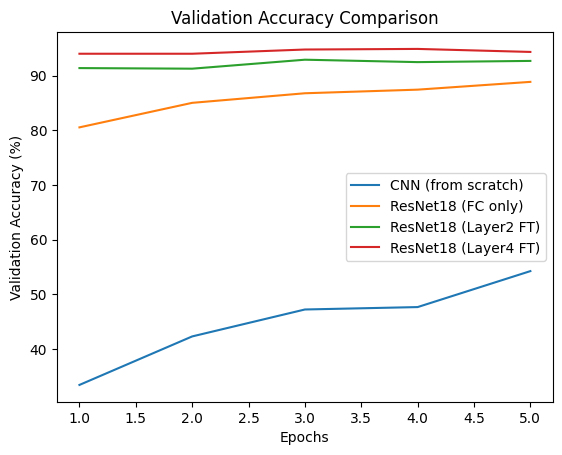

In [83]:
epochs = [1, 2, 3, 4, 5]

plt.figure()
plt.plot(epochs, cnn_val_acc, label="CNN (from scratch)")
plt.plot(epochs, fc_val_acc, label="ResNet18 (FC only)")
plt.plot(epochs, l2_val_acc, label="ResNet18 (Layer2 FT)")
plt.plot(epochs, l4_val_acc, label="ResNet18 (Layer4 FT)")

plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy (%)")
plt.title("Validation Accuracy Comparison")
plt.legend()
plt.show()


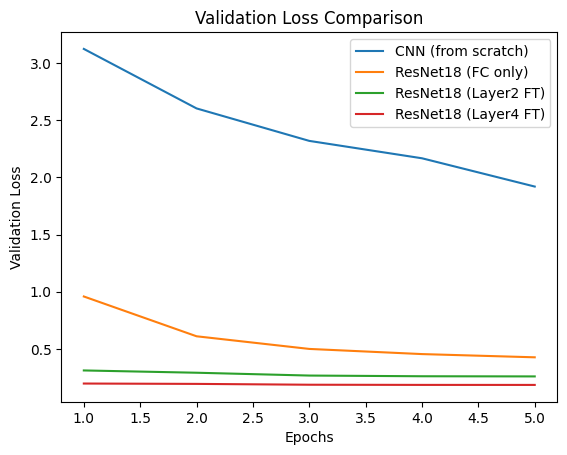

In [84]:
plt.figure()
plt.plot(epochs, cnn_val_loss, label="CNN (from scratch)")
plt.plot(epochs, fc_val_loss, label="ResNet18 (FC only)")
plt.plot(epochs, l2_val_loss, label="ResNet18 (Layer2 FT)")
plt.plot(epochs, l4_val_loss, label="ResNet18 (Layer4 FT)")

plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Comparison")
plt.legend()
plt.show()
